# Training an USE[DAN] Model

This Notebook defines a pipeline to train a dense neural network based on a DAN-Model. You can chose two settings: 

1. All your input text is treated as normal text
2. Your input text file will be splitt up in sentences

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## General Information & Label Map

### Directories

In [8]:
classifier_name = "name_date" # Name of the model is at the same time the dir where model files will be stored
classifier_dir = os.path.abspath(classifier_name)
# label_map = "" # path to label map (not implemented yet..)
data_dir = "../datasets/daniel_0712" # Where text data are stored
test_dir = "../datasets/eval_data"

In [9]:
if not os.path.isdir(classifier_dir):
    os.mkdir(classifier_dir)
    print("model dir created!")
else:
    print("model dir already exists")

model dir created!


### Model (Classifier) & Training Parameters

In [10]:
# Training Parameters
batch_size = 128
num_epochs = 150 
training_steps = 200000 # Seems to be ok for the beginning. Normally the training should stop when all epoches are done but it doesnt..

# Model Parameters
num_classes = 3 # ADJUST THAT
hidden_units = [500,100] # Iterable of number hidden units per layer. 
activation_fn=tf.nn.relu
optimizer = tf.train.AdadeltaOptimizer(learning_rate=0.001)
dropout = None # None or float 0-1
batch_normalization = False
regularization = False

### Label Map

In [11]:
# Use the label_map class from you package..
def get_label_id(class_name:str):
    if class_name == "clustering":   
        return 0
    if class_name == "frequent_pattern_mining":
        return 1
    if class_name == "prediction":
        return 2

In [12]:
# For plots below
labels = ["clustering",
          "frequent_pattern_mining",
          "prediction"] 

## Environment for TF-HUB Model

In [13]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

In [14]:
# I dont know if he overwrites the model during retraining.
embedding_model_url = "https://tfhub.dev/google/universal-sentence-encoder/2" 

In [15]:
import hashlib
# The path where tf-hub will cache the model (use an absolute path..) 
os.environ["TFHUB_CACHE_DIR"] = os.path.join(classifier_dir, "embedding_model")

#TF-hub will store the name as hex
embedding_model_hash = hashlib.sha1(classifier_dir.encode("utf8")).hexdigest()
print(embedding_model_hash)

419b2b3084fae7c4784fd6ce806e7ef02ec4c87a


## Loading Data into Dataframe

In [16]:
from nltk.tokenize import sent_tokenize

In [17]:
def read_data(_dir:str, sentence_level = True):
    data = {}
    data["text"] = []
    data["class"] = []
    for root, dirs, files in os.walk(_dir):
        for _dir in dirs: 
            for txt_file in [x for x in os.listdir(os.path.join(root, _dir)) if x.endswith((".txt", ".TXT"))]:
                # Class name = dir name
                class_name = _dir
                #Read File
                file_name = os.path.join(root, _dir, txt_file)
                file = open(file_name, "r")
                txt = file.read()
                file.close()
                if sentence_level:
                    # Txt to List[Sentences]
                    sentences = sent_tokenize(txt)
                    # Abstracts
                    for sentence in sentences:
                        data["text"].append(sentence)
                        data["class"].append(get_label_id(class_name))
                else:
                    data["text"].append(txt)
                    data["class"].append(get_label_id(class_name))
    df = pd.DataFrame.from_dict(data)
    del data
    return df

In [18]:
%%time
df = read_data(data_dir, sentence_level = False)

CPU times: user 496 ms, sys: 919 ms, total: 1.41 s
Wall time: 2.12 s


## Data Overview

In [38]:
pd.set_option('display.max_colwidth', -1)

In [41]:
df.sample(frac=1).head(3)

,text,class
8118,"A new approach for signal parametrization, which consists of a specific\nregression model incorporating a discrete hidden logistic process, is proposed.",NaN
1892,"Restricted Boltzmann machines (RBM) and its variants have become hot research\ntopics recently, and widely applied to many classification problems, such as\ncharacter recognition and document categorization. Often, classification RBM\nignores the interclass relationship or prior knowledge of sharing information\namong classes. In this paper, we are interested in RBM with the hierarchical\nprior over classes. We assume parameters for nearby nodes are correlated in the\nhierarchical tree, and further the parameters at each node of the tree be\northogonal to those at its ancestors. We propose a hierarchical correlated RBM\nfor classification problem, which generalizes the classification RBM with\nsharing information among different classes. In order to reduce the redundancy\nbetween node parameters in the hierarchy, we also introduce orthogonal\nrestrictions to our objective function. We test our method on challenge\ndatasets, and show promising results compared to competitive baselines.\n",NaN
3546,"Graphs can be used to represent a wide variety of data belonging to different\ndomains. Graphs can capture the relationship among data in an efficient way,\nand have been widely used. In recent times, with the advent of Big Data, there\nhas been a need to store and compute on large data sets efficiently. However,\nconsidering the size of the data sets in question, finding optimal methods to\nstore and process the data has been a challenge. Therefore, in this paper, we\nstudy different graph compression techniques and propose novel algorithms to do\nthe same. Specifically, given a graph G = (V, E), where V is the set of\nvertices and E is the set of edges, and |V| = n, we propose techniques to\ncompress the adjacency matrix representation of the graph. Our algorithms are\nbased on finding patterns within the adjacency matrix data, and replacing the\ncommon patterns with specific markers. All the techniques proposed here are\nlossless compression of graphs. Based on the experimental results, it is\nobserved that our proposed techniques achieve almost 70% compression as\ncompared to adjacency matrix representation. The results show that large graphs\ncan be efficiently stored in smaller memory and exploit the parallel processing\npower of compute nodes as well as efficiently transfer data between resources.\n",NaN


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8240 entries, 0 to 8239
Data columns (total 2 columns):
text     8240 non-null object
class    2271 non-null float64
dtypes: float64(1), object(1)
memory usage: 128.8+ KB


## Train and Test Split

In [21]:
df = shuffle(df) # Shuffle the DataFrame
X, Y = train_test_split(df, test_size=0.2, random_state = 101)

In [31]:
X.head(3)

,text,class
5444,"We thus avoid discrete reconfigurations of the\nobjective that characterize prior clustering algorithms.Experiments on\ndatasets from multiple domains demonstrate that the presented algorithm\noutperforms state-of-the-art clustering schemes, including recent methods that\nuse deep networks.",0.0
3124,"This paper presents an algebro-geometric solution to the problem of\nsegmenting an unknown number of subspaces of unknown and varying dimensions\nfrom sample data points. We represent the subspaces with a set of homogeneous\npolynomials whose degree is the number of subspaces and whose derivatives at a\ndata point give normal vectors to the subspace passing through the point. When\nthe number of subspaces is known, we show that these polynomials can be\nestimated linearly from data; hence, subspace segmentation is reduced to\nclassifying one point per subspace. We select these points optimally from the\ndata set by minimizing certain distance function, thus dealing automatically\nwith moderate noise in the data. A basis for the complement of each subspace is\nthen recovered by applying standard PCA to the collection of derivatives\n(normal vectors). Extensions of GPCA that deal with data in a high- dimensional\nspace and with an unknown number of subspaces are also presented. Our\nexperiments on low-dimensional data show that GPCA outperforms existing\nalgebraic algorithms based on polynomial factorization and provides a good\ninitialization to iterative techniques such as K-subspaces and Expectation\nMaximization. We also present applications of GPCA to computer vision problems\nsuch as face clustering, temporal video segmentation, and 3D motion\nsegmentation from point correspondences in multiple affine views.\n",NaN
3262,"The online analytical processing (OLAP) does not provide any explanation of\ncorrelations discovered between data. Thus, the coupling of OLAP and data\nmining, especially association rules, is considered as an efficient solution to\nthis problem. In this context, we mainly focus on a particular class of\nassociation rules which is the cyclic association rules. These rules aimed to\ndiscover patterns that display regular variation over user-defined intervals.\nGenerally,the generated patterns do not take an advantage from the\nspecificities of the multidimensional context namely, the consideration of the\nmeasures and their aggregations. In this paper, we introduce a novel method for\nextracting cyclic association rules from measures, and we redefine the\nevaluation metrics of association rules quality inspired of the temporal\nsummarizability of measures concept through the integration of appropriate\naggregation functions. To prove the usefulness of our approach, we conduct an\nempirical study on a real data warehouse.\n",NaN


In [32]:
Y.head(3)

,text,class
7973,"P-splines), with the noticeable difference that\nthe output is a sparse spline regression with a small number of knots.We show\nthat our method called A-spline, for adaptive splines yields sparse regression\nmodels with high interpretability, while having similar predictive performance\nsimilar to penalized spline regression methods.A-spline is applied both to\nsimulated and real dataset.",NaN
5260,"Thousands of first-millennium BCE ivory carvings have been excavated from\nNeo-Assyrian sites in Mesopotamia (primarily Nimrud, Khorsabad, and Arslan\nTash) hundreds of miles from their Levantine production contexts. At present,\ntheir specific manufacture dates and workshop localities are unknown. Relying\non subjective, visual methods, scholars have grappled with their classification\nand regional attribution for over a century. This study combines visual\napproaches with machine-learning techniques to offer data-driven perspectives\non the classification and attribution of this early Iron Age corpus. The study\nsample consisted of 162 sculptures of female figures. We have developed an\nalgorithm that clusters the ivories based on a combination of descriptive and\nanthropometric data. The resulting categories, which are based on purely\nstatistical criteria, show good agreement with conventional art historical\nclassifications, while revealing new perspectives, especially with regard to\nthe contested Syrian/South Syrian/Intermediate tradition. Specifically, we have\nidentified that objects of the Syrian/South Syrian/Intermediate tradition may\nbe more closely related to Phoenician objects than to North Syrian objects; we\noffer a reconsideration of a subset of Phoenician objects, and we confirm\nSyrian/South Syrian/Intermediate stylistic subgroups that might distinguish\nnetworks of acquisition among the sites of Nimrud, Khorsabad, Arslan Tash and\nthe Levant. We have also identified which features are most significant in our\ncluster assignments and might thereby be most diagnostic of regional carving\ntraditions. In short, our study both corroborates traditional visual\nclassification methods and demonstrates how machine-learning techniques may be\nemployed to reveal complementary information not accessible through the\nexclusively visual analysis of an archaeological corpus.\n",0.0
4662,"For the evaluation, we use two\nwell-known clustering algorithms, K-Means and DBSCAN.One of the key outputs of\nthis distributed clustering technique is that the number of global clusters is\ndynamic, no need to be fixed in advance.Experimental results show that the\napproach is scalable and produces high quality results.",0.0


In [24]:
print("Train Data: \n")
print(X.info())
print("\n Test Data: \n")
print(Y.info())

Train Data: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6592 entries, 5444 to 2755
Data columns (total 2 columns):
text     6592 non-null object
class    1821 non-null float64
dtypes: float64(1), object(1)
memory usage: 154.5+ KB
None

 Test Data: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1648 entries, 7973 to 6851
Data columns (total 2 columns):
text     1648 non-null object
class    450 non-null float64
dtypes: float64(1), object(1)
memory usage: 38.6+ KB
None


## Training

### Constructing Feature Columns

In [42]:
%%time
tf.logging.set_verbosity(tf.logging.INFO)
embedded_text_feature_column = hub.text_embedding_column(
    key="text", 
    module_spec=embedding_model_url,
    trainable = True)

INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 18.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 38.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 58.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 78.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 98.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 118.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 138.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 148.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 168.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encode

In [26]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [27]:
# Only keep two checkpoints files because memory on server is limited
estimator_config = tf.estimator.RunConfig(keep_checkpoint_max=2)

In [43]:
# See information section at the beginning
estimator = tf.estimator.DNNClassifier(
    hidden_units= hidden_units,
    feature_columns=[embedded_text_feature_column],
    model_dir = classifier_dir,
    activation_fn=activation_fn,
    n_classes=num_classes,
    dropout = dropout,
    batch_norm=batch_normalization,
    optimizer=optimizer,
    config=estimator_config)

INFO:tensorflow:Using config: {'_model_dir': '/Users/Daniel/PycharmProjects/Recommender-System/notebooks/test_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 2, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x105762860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Defining Input Functions

In [23]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    X, 
    X["class"],
    num_epochs=num_epochs,
    batch_size= batch_size,
    shuffle = False)

# Prediction on the whole training set.
predict_insampling_input_fn = tf.estimator.inputs.pandas_input_fn(
    X, X["class"], shuffle=False)

# Prediction on the test set.
predict_outsampling_input_fn = tf.estimator.inputs.pandas_input_fn(
    Y, Y["class"], shuffle=False)

### Training of the Classifier

In [24]:
%%time
tf.logging.set_verbosity(tf.logging.INFO)
estimator.train(input_fn=train_input_fn, steps=training_steps);

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /Users/Daniel/PycharmProjects/Recommender-System/notebooks/test_model/model.ckpt.
INFO:tensorflow:loss = 13.930591, step = 1
INFO:tensorflow:Saving checkpoints for 1 into /Users/Daniel/PycharmProjects/Recommender-System/notebooks/test_model/model.ckpt.
INFO:tensorflow:Loss for final step: 

## Evaluation

In [36]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [37]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

### Insampling

In [39]:
results = estimator.evaluate(input_fn=predict_insampling_input_fn)

print("Results: \n")
print(results)

Results: 

{'accuracy': 0.25599864, 'average_loss': 1.3835783, 'loss': 176.62039, 'global_step': 1}


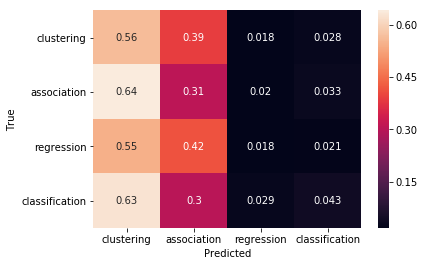

In [41]:
with tf.Graph().as_default():
    cm = tf.confusion_matrix(X["class"], get_predictions(estimator, predict_insampling_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=labels, yticklabels=labels);
plt.xlabel("Predicted");
plt.ylabel("True");

### Outsampling

In [42]:
results = estimator.evaluate(input_fn=predict_outsampling_input_fn)

print("Results: \n")
print(results)

Results: 

{'accuracy': 0.25452828, 'average_loss': 1.3835768, 'loss': 175.18788, 'global_step': 1}


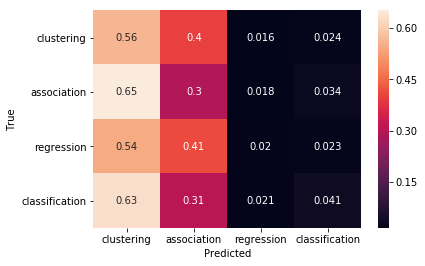

In [43]:
with tf.Graph().as_default():
    cm = tf.confusion_matrix(Y["class"], get_predictions(estimator, predict_outsampling_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=labels, yticklabels=labels);
plt.xlabel("Predicted");
plt.ylabel("True");

### Test Set

#### Read Test Data

In [34]:
df_test = read_data(test_dir, sentence_level = False)

In [35]:
shuffle(df_test.head(5))

,text,class


#### Defining Input Function

In [55]:
# Prediction on the whole training set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    df_test, df_test["class"], shuffle=True)

#### Evaluation of Test Set

In [56]:
results = estimator.evaluate(input_fn=predict_test_input_fn)

print("Results: \n")
print(results)

Results: 

{'accuracy': 0.3, 'average_loss': 1.3803766, 'loss': 27.607533, 'global_step': 1}


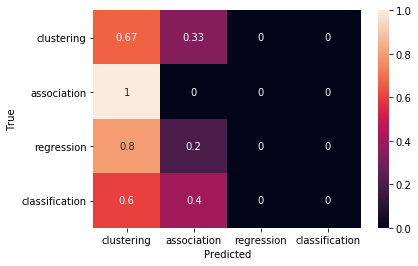

In [57]:
with tf.Graph().as_default():
    cm = tf.confusion_matrix(df_test["class"], get_predictions(estimator, predict_test_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=labels, yticklabels=labels);
plt.xlabel("Predicted");
plt.ylabel("True");

## Inference for each Test Data File

In [80]:
df_inference = pd.DataFrame.from_dict({"text": df_test["text"]})
inference_func = tf.estimator.inputs.pandas_input_fn(df_inference, shuffle=False)

In [89]:
results = estimator.predict(inference_func)
y = []
probs =[]
for x in results:
    y.append(x["class_ids"])
    probs.append(x["probabilities"])
df_test["predicted"] = y
df_test["probs"] = probs

In [90]:
pd.set_option('display.max_colwidth', -1)
df_test

,text,class,predicted,probs
0,I want a forecasting of the used machine types in my assembly line.,3,[0],"[0.26093316, 0.25915012, 0.25016004, 0.22975671]"
1,Not based on numerical features.,3,[0],"[0.25667354, 0.25535163, 0.24522372, 0.24275109]"
2,Given a arbitrary text of the world library the software should classify the author.,3,[0],"[0.26328275, 0.25517595, 0.23295455, 0.24858673]"
3,The project describes the problem of recognizing objects in images.,3,[0],"[0.26405403, 0.24664634, 0.24863827, 0.24066138]"
4,The main objective is to detect different car brands in one picture.,3,[0],"[0.26617894, 0.25238276, 0.23944362, 0.24199477]"
5,"The purpose of this project is to segment supply chain partners in the automobile industry, according to their provided quality.",0,[0],"[0.2643476, 0.25394645, 0.25034013, 0.23136574]"
6,Our company has a variety of different costumers.,0,[0],"[0.26106918, 0.25313938, 0.24082673, 0.24496472]"
7,"Based on the costumer types as well of their revenues, different costumer groups should be found.",0,[0],"[0.26276815, 0.24651077, 0.25111374, 0.23960736]"
8,I want to group my machines according to their energy consumption.,0,[1],"[0.2512538, 0.2602064, 0.24818558, 0.24035424]"
9,Machines with a similar energy consumption should be grouped together.,0,[0],"[0.26045293, 0.25245857, 0.2506396, 0.23644893]"


## Semantic Textual Similarity

#### Function and Sentences for Similarity Matrix

In [58]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
    message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
    plot_similarity(messages_, message_embeddings_, 90)

In [62]:
clustering_0 = "finding similar groups"
clustering_1 = "clustering things"
pattern_mining_0 = "analysing sequences"
pattern_mining_1 = "finding pattern"
classification_0 = "predicting categorical types"
classification_1 = "classifing objects"
regression_0 = "predicting prices"
regression_1 = "forecasting numbers"

messages = [clustering_0,
            clustering_1,
            pattern_mining_0,
            pattern_mining_1,
            classification_0,
            classification_1,
            regression_0,
            regression_1]

#### Similarity Matrix

__This only works on CPU. TF-BUG: https://github.com/tensorflow/hub/issues/94__